# Step 3. Data training and evaluate models
Compare several machine learning models on a performance metric

Perform hyperparameter tuning on the best model to optimize it for the problem

Step 1. [Data exploration](/notebooks/forex/mark2/1_data_explore.ipynb)

Step 2. [Feature engineering](/notebooks/forex/mark2/2_feature_engineering.ipynb)

Step 3. **Data training and models evaluation**

# Import

In [41]:
%matplotlib inline
from math import sqrt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import talib as ta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import Imputer, MinMaxScaler

import optunity
import sklearn
from optunity import cross_validated
from optunity.metrics import mse
import warnings
warnings.filterwarnings('ignore')

csv_path = 'data/EURUSD_Candlestick_1_Hour_ASK_01.05.2017-18.05.2019_featured.csv'
take_profit = 40
stop_loss = 30

# Load data

In [13]:
df = pd.read_csv(csv_path,
                 header=0,
                 parse_dates=True)
df.set_index('time')
print(len(df))
df.tail()

12761


,time,open,high,low,close,volume,hour,volatility,rsi,stoch_slowk,...,cci,ultosc,hour_sin,hour_cos,max_buy,max_buy_count,max_sell,max_sell_count,is_buy_profit,is_sell_profit
12756,2019-05-17 16:00:00,1.11651,1.11694,1.11640,1.11647,12190.32,16,5.4,40.01878,42.70297,...,-68.96251,52.41159,-0.86603,-0.50000,2.3,3,-9.3,4,False,False
12757,2019-05-17 17:00:00,1.11646,1.11670,1.11614,1.11650,12731.28,17,5.6,40.32716,44.04303,...,-75.39102,51.01559,-0.96593,-0.25882,2.0,1,-9.6,3,False,False
12758,2019-05-17 18:00:00,1.11649,1.11649,1.11593,1.11593,8851.12,18,5.6,36.48866,35.16583,...,-101.13716,42.50975,-1.00000,-0.00000,7.7,2,-3.9,2,False,False
12759,2019-05-17 19:00:00,1.11593,1.11670,1.11592,1.11607,17097.71,19,7.8,38.04841,27.98237,...,-78.26676,38.94281,-0.96593,0.25882,0.6,1,-5.3,1,False,False
12760,2019-05-17 20:00:00,1.11606,1.11613,1.11554,1.11582,4685.08,20,5.9,36.33250,27.23266,...,-121.55542,42.78488,-0.86603,0.50000,0.0,0,0.0,0,False,False


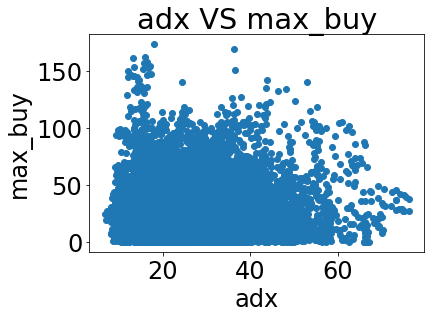

In [14]:
plt.scatter(df['adx'],df['max_buy'])
plt.title("adx VS max_buy")
plt.ylabel("max_buy")
plt.xlabel("adx")
plt.show()

# Scaling Features

In [15]:
# max cci = 350
df['cci'] = df['cci'].apply(lambda x: 350 if x > 350 else x)
df['cci'] = df['cci'].apply(lambda x: -350 if x < -350 else x)

df['cci'].describe()

count    12748.000000
mean         1.338446
std        115.346233
min       -350.000000
25%        -83.736030
50%          4.264375
75%         87.054832
max        350.000000
Name: cci, dtype: float64

In [16]:
df['rsi'] = df['rsi'] / 100
df['stoch_slowk'] = df['stoch_slowk'] / 100
df['stoch_slowd'] = df['stoch_slowd'] / 100
df['stochrsi_fastk'] = df['stochrsi_fastk'] / 100
df['stochrsi_fastd'] = df['stochrsi_fastd'] / 100
df['adx'] = df['adx'] / 100
df['williams_r'] = (df['williams_r'] + 100) / 100
df['cci'] = df['cci'] + 350
df['cci'] = df['cci'] / 700
df['ultosc'] = df['ultosc'] / 100

In [17]:
for x in [
        'rsi', 'stoch_slowk', 'stoch_slowd', 'stochrsi_fastk',
        'stochrsi_fastd', 'adx', 'williams_r', 'cci', 'ultosc'
]:
    print(x,df[x].min(), df[x].max())

rsi 0.12690590000000002 0.9205115
stoch_slowk 0.0264704 0.9862359
stoch_slowd 0.033708999999999996 0.9791138
stochrsi_fastk 0.0 1.0
stochrsi_fastd -0.0 1.0
adx 0.0665423 0.7627457
williams_r 0.0 1.0
cci 0.0 1.0
ultosc 0.1643647 0.8514667


# Traning data and test

In [18]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'hour', 'volatility',
       'rsi', 'stoch_slowk', 'stoch_slowd', 'stochrsi_fastk', 'stochrsi_fastd',
       'adx', 'williams_r', 'cci', 'ultosc', 'hour_sin', 'hour_cos', 'max_buy',
       'max_buy_count', 'max_sell', 'max_sell_count', 'is_buy_profit',
       'is_sell_profit'],
      dtype='object')

In [19]:
df = df.dropna()
start_hour = 8
end_hour = 16

test_df = df[(df['time'] > '2019-01-22 14:00:00') & (df['hour'] > start_hour)
             & (df['hour'] < end_hour)]
buy_test_y = np.array(test_df['max_buy']).reshape((-1, ))
sell_test_y = np.array(test_df['max_sell']).reshape((-1, ))
# test_df.drop([
#     'time', 'open', 'high', 'low', 'close', 'volume', 'hour', 'volatility',
#     'stochrsi_fastk', 'hour_sin', 'hour_cos', 'max_buy', 'max_buy_count',
#     'max_sell', 'max_sell_count', 'is_buy_profit', 'is_sell_profit'
# ],
#              axis=1,
#              inplace=True)

test_x = test_df.as_matrix(columns=[
    'rsi', 'adx', 'williams_r','cci'
])
print(test_x.shape, buy_test_y.shape, sell_test_y.shape)

(582, 4) (582,) (582,)


In [20]:
train_df = df[(df['time'] <= '2019-01-22 14:00:00') & (df['hour'] > start_hour)
              & (df['hour'] < end_hour)]
buy_train_y = np.array(train_df['max_buy']).reshape((-1, ))
sell_train_y = np.array(train_df['max_sell']).reshape((-1, ))
train_x = train_df.as_matrix(columns=[
    'rsi', 'adx', 'williams_r','cci'
])
print(train_x.shape, buy_train_y.shape, sell_train_y.shape)

(3128, 4) (3128,) (3128,)


# Mean Absolute Error as metrics function

In [49]:
def weighted_metric(y_true, y_pred):
    # large volatility -> small error
    # small volatility -> large error
    total = 0
    for i in range(len(y_true)):
        true = y_true[i]
        pred = y_pred[i]
        if true > stop_loss and pred > stop_loss:
            total += abs(abs(true) - abs(pred))
        else:
            pass


# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))


# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model, metric, xx, yy, test_xx, test_yy):

    # Train the model
    model.fit(xx, yy)

    # Make predictions and evalute
    model_pred = model.predict(test_xx)
    model_error = metric(test_yy, model_pred)

    # Return the performance metric
    return model_error

# Regression Models to Evaluate

In [24]:
# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# BUY direction

In [50]:
# Linear regression

lr = LinearRegression()
lr_mae = fit_and_evaluate(lr,mse, train_x, buy_train_y, test_x, buy_test_y)

print('Linear Regression Performance on the test set: MSE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MSE = 421.3058


In [59]:
# SVM

svm = SVR(C=1000, gamma=0.1)
svm_mae = fit_and_evaluate(svm, mse, train_x, buy_train_y, test_x, buy_test_y)

print(
    'Support Vector Machine Regression Performance on the test set: MSE = %0.4f'
    % svm_mae)

Support Vector Machine Regression Performance on the test set: MSE = 344.7496


In [52]:
# Random forest

random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest, mse, train_x, buy_train_y,
                                     test_x, buy_test_y)

print('Random Forest Regression Performance on the test set: MSE = %0.4f' %
      random_forest_mae)

Random Forest Regression Performance on the test set: MSE = 559.2692


In [53]:
# Gradien boosted

gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted, mse, train_x,
                                        buy_train_y, test_x, buy_test_y)

print('Gradient Boosted Regression Performance on the test set: MSE = %0.4f' %
      gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MSE = 442.8487


In [55]:
# KNN

knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn, mse, train_x, buy_train_y, test_x, buy_test_y)

print(
    'K-Nearest Neighbors Regression Performance on the test set: MSE = %0.4f' %
    knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MSE = 482.9366


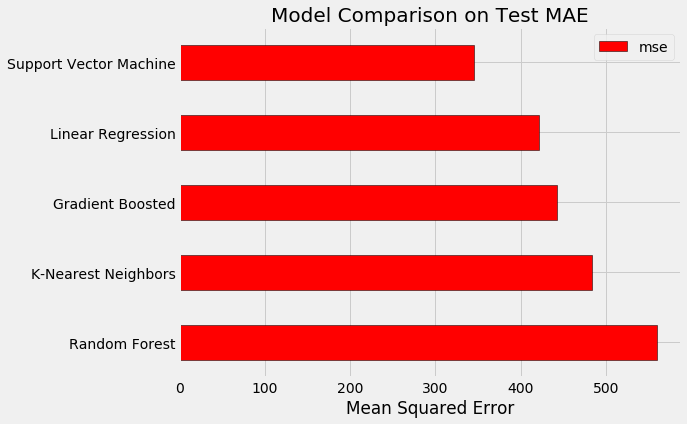

In [57]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mse': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mse', ascending = False).plot(x = 'model', y = 'mse', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Squared Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

In [39]:
buy_test_y.shape
test_x.shape
mae([0, 0, 1, 1], [0, 0, 4, 1])

0.75

# Model Optimization

SVR is the best one, will select SVM to do Optimization and Hyperparameter Tuning.

## SVR default hyperparameters

In [60]:
# we explicitly generate the outer_cv decorator so we can use it twice
outer_cv = optunity.cross_validated(x=train_x, y=buy_train_y, num_folds=5)

def compute_mse_standard(x_train, y_train, x_test, y_test):
    """Computes MSE of an SVR with RBF kernel and default hyperparameters."""
    model = SVR(C = 1000, gamma = 0.1).fit(x_train, y_train)
    predictions = model.predict(x_test)
    return mse(y_test, predictions)

# wrap with outer cross-validation
compute_mse_standard = outer_cv(compute_mse_standard)
value=compute_mse_standard()
print(f'{value} = 5-folds cross-validation estimate of MSE with default hyperparameters')


642.0533163932985 = 5-folds cross-validation estimate of MSE with default hyperparameters


### RBF kernal

In [62]:
counter = 0

# we explicitly generate the outer_cv decorator so we can use it twice
outer_cv = optunity.cross_validated(x=train_x, y=buy_train_y, num_folds=5)


def compute_mse_rbf_tuned(x_train, y_train, x_test, y_test):
    """Computes MSE of an SVR with RBF kernel and optimized hyperparameters."""

    # define objective function for tuning
    @optunity.cross_validated(x=x_train, y=y_train, num_iter=2, num_folds=5)
    def tune_cv(x_train, y_train, x_test, y_test, logC, logGamma):
        model = sklearn.svm.SVR(C=10**logC,
                                gamma=10**logGamma).fit(x_train, y_train)
        predictions = model.predict(x_test)
        global counter
        counter += 1
        return optunity.metrics.mse(y_test, predictions)

    # optimize parameters
    optimal_pars, _, _ = optunity.minimize(tune_cv,
                                           num_evals=50,
                                           logC=[-5, 5],
                                           logGamma=[-5, 5])

    tuned_model = sklearn.svm.SVR(C=10**optimal_pars.get('logC'),
                                  gamma=10**optimal_pars.get('logGamma')).fit(
                                      x_train, y_train)
    predictions = tuned_model.predict(x_test)
    mse_value = optunity.metrics.mse(y_test, predictions)
    
    global counter
    print("%s optimal hyperparameters: %s = %s" % (counter, optimal_pars, mse_value))
    return mse_value


# wrap with outer cross-validation
compute_mse_rbf_tuned = outer_cv(compute_mse_rbf_tuned)
compute_mse_rbf_tuned()

350 optimal hyperparameters: {'logC': 2.0662109374999997, 'logGamma': 4.897038640278602} = 582.6534759759332
810 optimal hyperparameters: {'logC': 2.325797456558583, 'logGamma': 4.6380859375} = 635.0049613359239
1310 optimal hyperparameters: {'logC': 0.44843750000000027, 'logGamma': 3.457162151558221} = 549.5931947134342
1710 optimal hyperparameters: {'logC': 3.643420846075526, 'logGamma': 4.151637814159438} = 673.1652833001344
2210 optimal hyperparameters: {'logC': 0.5476562499999997, 'logGamma': 2.6635171416259182} = 608.0401139503831


609.6914058551617

50 optimal hyperparameters: {'logC': 0.8251953125, 'logGamma': 3.8916015625} = 746.755235124794

100 optimal hyperparameters: {'logC': 1.8994140625, 'logGamma': 4.3798828125} = 606.4509590631386

150 optimal hyperparameters: {'logC': 3.2763671875, 'logGamma': -4.7705078125} = 635.2671289270351

200 optimal hyperparameters: {'logC': -0.107421875, 'logGamma': 4.208984375} = 612.4016817613954

250 optimal hyperparameters: {'logC': -0.3173828125, 'logGamma': 4.1357421875} = 560.9439632659183

632.3637936284563

### Poly kernal

In [25]:
import warnings
warnings.filterwarnings('ignore')

# we explicitly generate the outer_cv decorator so we can use it twice
outer_cv = optunity.cross_validated(x=train_x, y=buy_train_y, num_folds=5)


# use poly kernal
def compute_mse_poly_tuned(x_train, y_train, x_test, y_test):
    """Computes MSE of an SVR with RBF kernel and optimized hyperparameters."""

    # define objective function for tuning
    @optunity.cross_validated(x=train_x,
                              y=buy_train_y,
                              num_iter=2,
                              num_folds=5)
    def tune_cv(x_train, y_train, x_test, y_test, C, degree, coef0):
        model = sklearn.svm.SVR(C=C, degree=degree, coef0=coef0,
                                kernel='poly').fit(x_train, y_train)
        predictions = model.predict(x_test)
        m = optunity.metrics.mse(y_test, predictions)
        return m

    # optimize parameters
    optimal_pars, _, _ = optunity.minimize(tune_cv,
                                           num_evals=50,
                                           C=[1000, 1001],
                                           degree=[2, 3],
                                           coef0=[0, 1])
    print("optimal hyperparameters: " + str(optimal_pars))

    tuned_model = sklearn.svm.SVR(kernel='poly',
                                  **optimal_pars).fit(x_train, y_train)
    predictions = tuned_model.predict(x_test)
    return optunity.metrics.mse(y_test, predictions)


# wrap with outer cross-validation
compute_mse_poly_tuned = outer_cv(compute_mse_poly_tuned)
compute_mse_poly_tuned()

optimal hyperparameters: {'C': 1000.893841145833, 'degree': 2.078815104166665, 'coef0': 0.18623697916666687}
optimal hyperparameters: {'C': 1000.6850698969025, 'degree': 2.3267390997815034, 'coef0': 0.4158163441989351}
optimal hyperparameters: {'C': 1000.1605641306761, 'degree': 2.3738505036848694, 'coef0': 0.01541886608240831}
optimal hyperparameters: {'C': 1000.5297864183988, 'degree': 2.4821780978670276, 'coef0': 0.03812318161467538}
optimal hyperparameters: {'C': 1000.4526429027724, 'degree': 2.4958529967616974, 'coef0': 0.19407643771580205}


362.82706641671484

In [195]:
import optunity
from optunity import cross_validated


# we explicitly generate the outer_cv decorator so we can use it twice
outer_cv = optunity.cross_validated(x=X, y=y, num_folds=5, num_iter=1)


# define objective function for tuning
@optunity.cross_validated(x=x_train, y=y_train, num_iter=1, num_folds=5)
def tune_cv(x_train, y_train, x_test, y_test, C, degree, coef0):
    model = sklearn.svm.SVR(C=C, degree=degree, coef0=coef0, kernel='poly').fit(x_train, y_train)
    predictions = model.predict(x_test)
    return optunity.metrics.mse(y_test, predictions)
    
def compute_mse_standard(x_train, y_train, x_test, y_test):
    """Computes MSE of an SVR with RBF kernel and default hyperparameters.
    """
    model = sklearn.svm.SVR().fit(x_train, y_train)
    predictions = model.predict(x_test)
    return optunity.metrics.mse(y_test, predictions)

# wrap with outer cross-validation
compute_mse_with_cv = outer_cv(compute_mse_standard)
compute_mse_with_cv()

NameError: name 'X' is not defined

In [ ]:
import optunity
import optunity.metrics
import sklearn.svm

# score function: twice iterated 10-fold cross-validated accuracy
@optunity.cross_validated(x=X, y=y, num_folds=10, num_iter=2)
def svm_auc(x_train, y_train, x_test, y_test, logC, logGamma):
    model = SVR(C=10 ** logC, gamma=10 ** logGamma).fit(x_train, y_train)
    predictions = model.predict(x_test)
    return mae(y_test, predictions)

# perform tuning
hps, _, _ = optunity.maximize(svm_auc, num_evals=10, logC=[-5, 5], logGamma=[-5, 5])
print(hps)

In [52]:
# manually grid search 
from itertools import product
combination = list(product(*[range(-3, 4), range(-4, 3)]))
result = []
for a, b in combination:
    svm = SVR(C=10**a, gamma=10**b)
    svm_mae = fit_and_evaluate(svm)
    result.append((10**a, 10**b, svm_mae))
    print(f'C={10 ** a}, gamma={10 ** b}  = {svm_mae}')

C=0.001, gamma=0.0001  = 3.7637078983794177
C=0.001, gamma=0.001  = 3.7636835461338305
C=0.001, gamma=0.01  = 3.763375913798129
C=0.001, gamma=0.1  = 3.7601455839443436
C=0.001, gamma=1  = 3.740820001029104
C=0.001, gamma=10  = 3.7131975881375197
C=0.01, gamma=0.0001  = 3.7636835436299436
C=0.01, gamma=0.001  = 3.7633845525066283
C=0.01, gamma=0.01  = 3.7601029219695508
C=0.01, gamma=0.1  = 3.738815357878329
C=0.01, gamma=1  = 3.695629439188367
C=0.01, gamma=10  = 3.6947023440239772
C=0.01, gamma=100  = 3.713421024452286
C=0.1, gamma=0.0001  = 3.7633726919599586
C=0.1, gamma=0.001  = 3.7600993550175548
C=0.1, gamma=0.01  = 3.7385843163792516
C=0.1, gamma=0.1  = 3.695796937757105
C=0.1, gamma=1  = 3.6903271645344176
C=0.1, gamma=10  = 3.6969897527009774
C=0.1, gamma=100  = 3.7088747548728236
C=1, gamma=0.0001  = 3.7600988760544656
C=1, gamma=0.001  = 3.738556286076489
C=1, gamma=0.01  = 3.695856933699899
C=1, gamma=0.1  = 3.69225265007057
C=1, gamma=1  = 3.6916386095096048
C=1, gamma=10

The best one is 

C=0.1, gamma=1, 3.6903271645344176

In [29]:
# train model on the full training set with tuned hyperparameters
optimal_model = SVR(C=0.1, gamma=1).fit(X, y)
model_pred = optimal_model.predict(X_test)
model_mae = mae(y_test, model_pred)
print(model_mae)

3.6903271645344176
